## Looking at COVID-19 Data

This notebook will show you:
1. How to make simple charts using tools like Matplotlib and Seaborn
2. How charts can sometimes be tricky and how to make them clearer
3. A small project using COVID-19 data to tell a story

In [1]:
!curl -o country_wise_latest.csv "https://files.0xarchit.is-a.dev/datasets/country_wise_latest.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 12732    0 12732    0     0  12606      0 --:--:--  0:00:01 --:--:-- 12630
100 14596    0 14596    0     0  14297      0 --:--:--  0:00:01 --:--:-- 14323


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('country_wise_latest.csv')
display(df.head())

,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,Confirmed last week,1 week change,1 week % increase,WHO Region
0,Afghanistan,36263,1269,25198,9796,106,10,18,3.50,69.49,5.04,35526,737,2.07,Eastern Mediterranean
1,Albania,4880,144,2745,1991,117,6,63,2.95,56.25,5.25,4171,709,17.00,Europe
2,Algeria,27973,1163,18837,7973,616,8,749,4.16,67.34,6.17,23691,4282,18.07,Africa
3,Andorra,907,52,803,52,10,0,0,5.73,88.53,6.48,884,23,2.60,Europe
4,Angola,950,41,242,667,18,1,0,4.32,25.47,16.94,749,201,26.84,Africa


## 1. Basic Visualizations

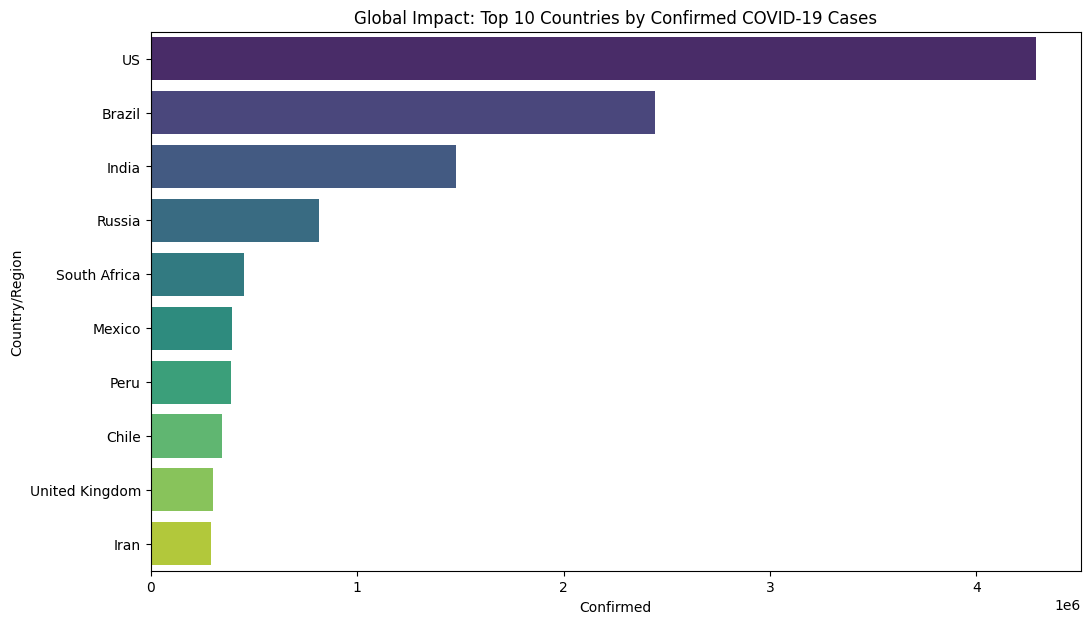

In [3]:
top10 = df.nlargest(10, 'Confirmed')
plt.figure(figsize=(12,7))
sns.barplot(x='Confirmed', y='Country/Region', data=top10, palette='viridis', hue='Country/Region', legend=False)
plt.title('Global Impact: Top 10 Countries by Confirmed COVID-19 Cases')
plt.show()

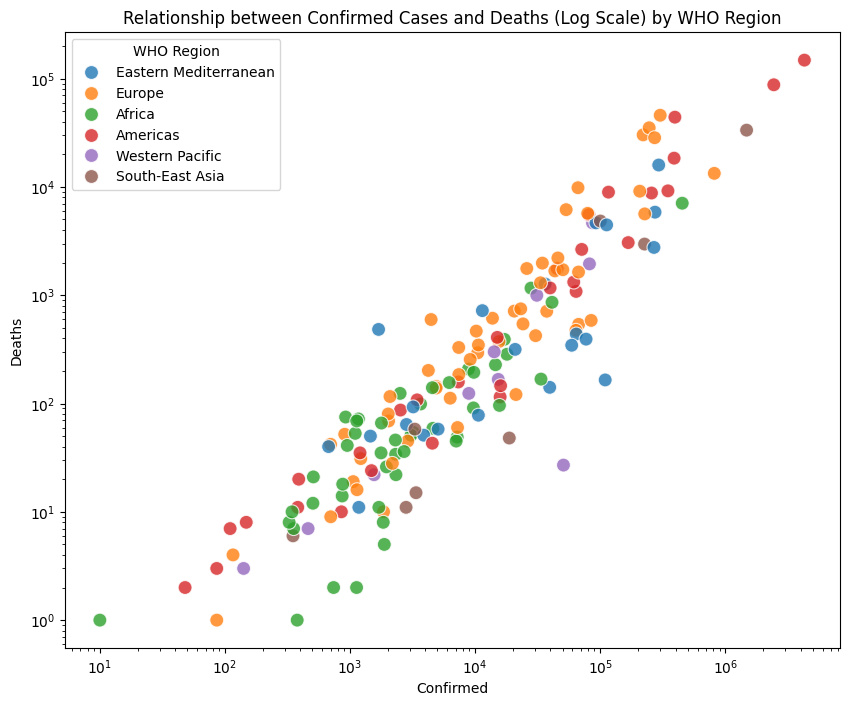

In [4]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='Confirmed', y='Deaths', data=df, hue='WHO Region', alpha=0.8, s=100)
plt.xscale('log')
plt.yscale('log')
plt.title('Relationship between Confirmed Cases and Deaths (Log Scale) by WHO Region')
plt.show()

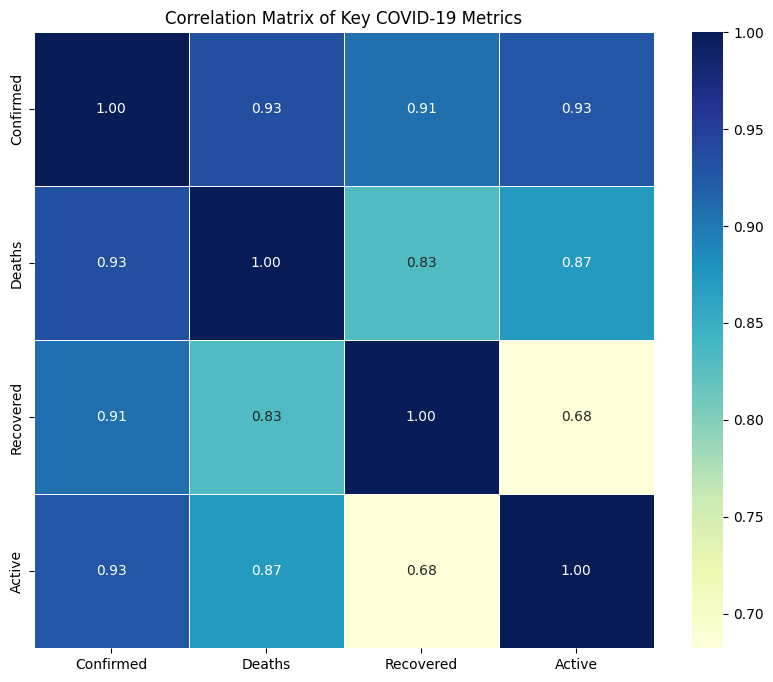

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(df[['Confirmed','Deaths','Recovered','Active']].corr(), annot=True, cmap='YlGnBu', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key COVID-19 Metrics')
plt.show()

## 2. Misleading Visualization Example

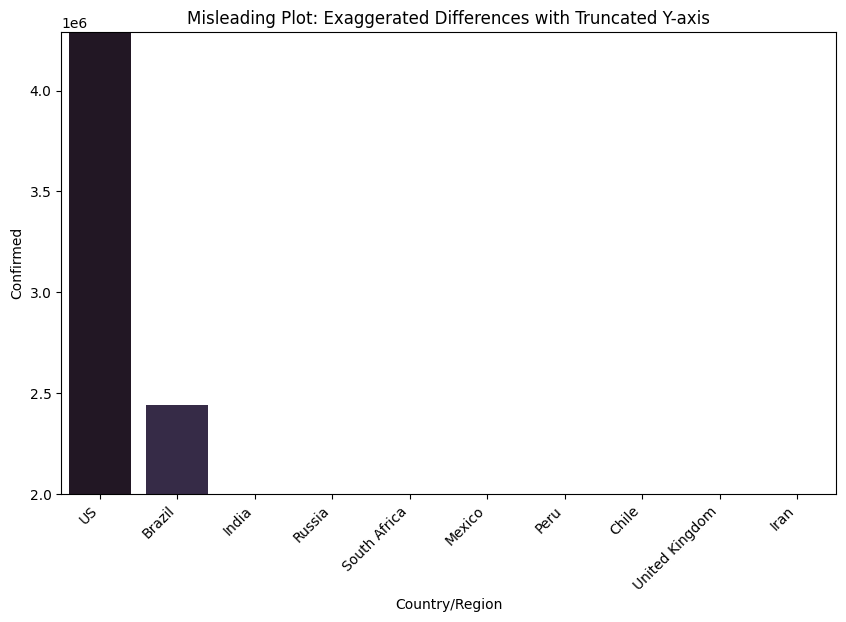

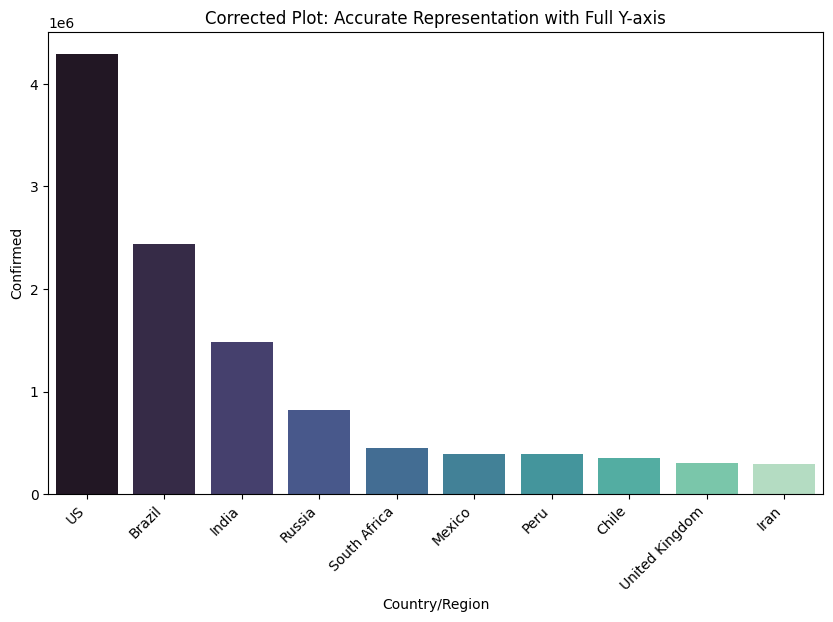

In [6]:
top10 = df.nlargest(10, 'Confirmed')

plt.figure(figsize=(10,6))
sns.barplot(x='Country/Region', y='Confirmed', data=top10, palette='mako', hue='Country/Region', legend=False)
plt.ylim(2000000, top10['Confirmed'].max())
plt.title('Misleading Plot: Exaggerated Differences with Truncated Y-axis')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='Country/Region', y='Confirmed', data=top10, palette='mako', hue='Country/Region', legend=False)
plt.title('Corrected Plot: Accurate Representation with Full Y-axis')
plt.xticks(rotation=45, ha='right')
plt.show()

## 3. Storytelling with COVID-19 Dataset

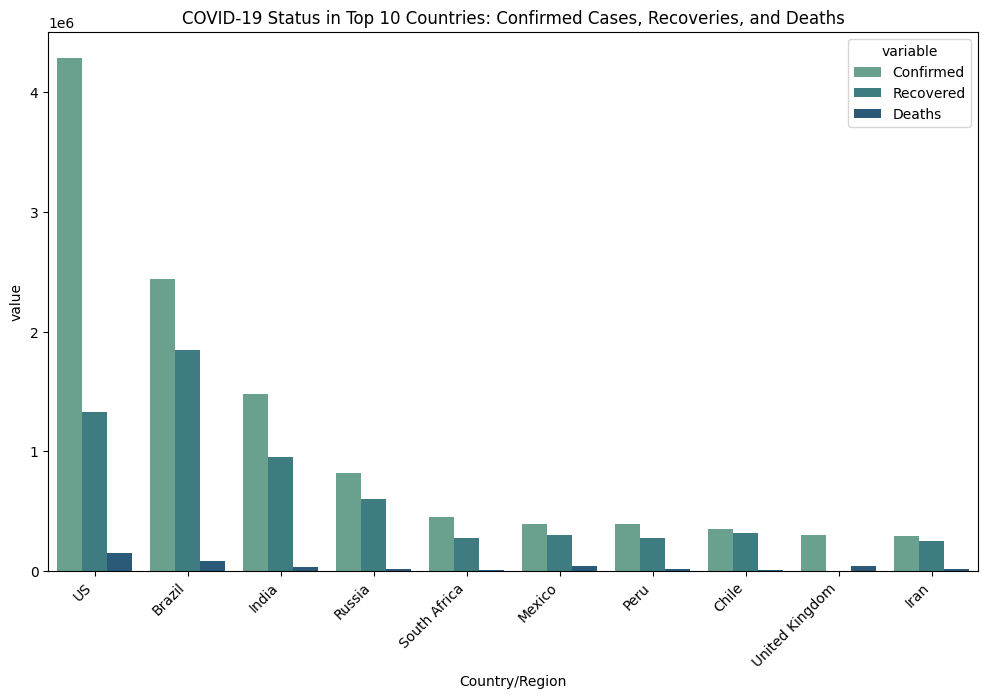

In [7]:
plt.figure(figsize=(12,7))
top10_melt = top10.melt(id_vars=['Country/Region'], value_vars=['Confirmed','Recovered','Deaths'])
sns.barplot(x='Country/Region', y='value', hue='variable', data=top10_melt, palette='crest')
plt.title('COVID-19 Status in Top 10 Countries: Confirmed Cases, Recoveries, and Deaths')
plt.xticks(rotation=45, ha='right')
plt.show()

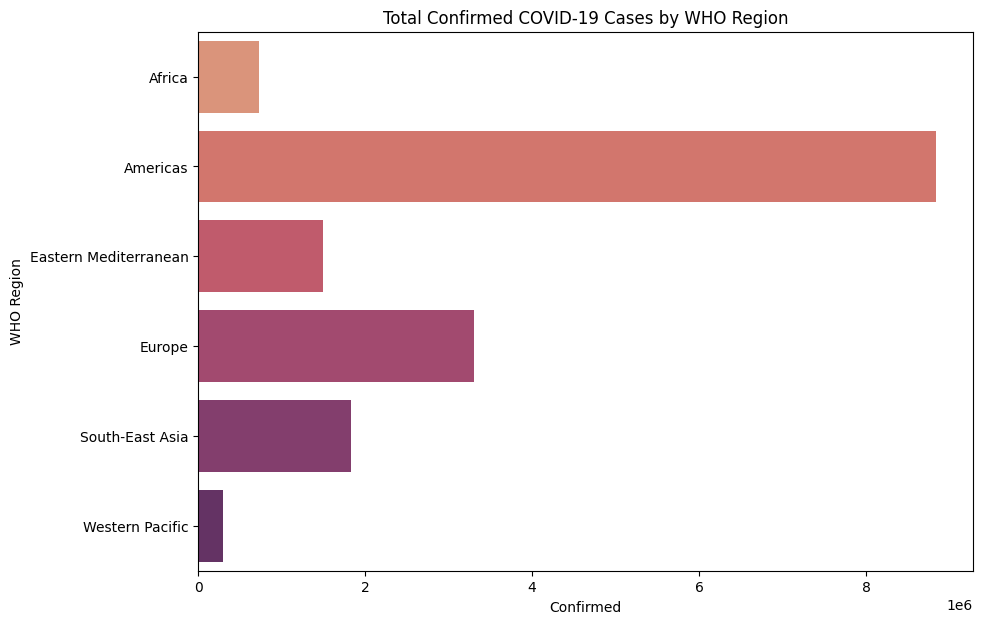

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('country_wise_latest.csv')

region_df = df.groupby('WHO Region')[['Confirmed','Deaths','Recovered']].sum().reset_index()
plt.figure(figsize=(10,7))
sns.barplot(x='Confirmed', y='WHO Region', data=region_df, palette='flare', hue='WHO Region', legend=False)
plt.title('Total Confirmed COVID-19 Cases by WHO Region')
plt.show()

## What We Learned:
- Some countries have a lot more COVID-19 cases than others.
- Using a special kind of scale (log scale) helps us see big differences easily.
- Be careful! Charts can sometimes be misleading, like when they don't show the whole picture.
- Looking at different areas helps us understand where cases are happening the most.

> ## **Streamlit**


In [9]:
!pip install --quiet streamlit pandas numpy seaborn matplotlib plotly folium pycountry

In [10]:
import os
os.makedirs('.streamlit', exist_ok=True)
config = '[server]\nheadless = true\nport = 8501\nenableCORS = false\n'
with open('.streamlit/config.toml', 'w', encoding='utf-8') as config_file:
    config_file.write(config)

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from streamlit.components.v1 import html
import folium
from folium.plugins import MiniMap, Fullscreen, MousePosition, Search, MeasureControl
import requests
import pycountry
import math

DATA_PATH = "https://files.0xarchit.is-a.dev/datasets/country_wise_latest.csv"

@st.cache_data
def load_data():
    return pd.read_csv(DATA_PATH)

def prepare_data(df):
    df = df.copy()
    df.columns = [col.strip() for col in df.columns]
    if "Country/Region" in df.columns:
        df = df.rename(columns={"Country/Region": "Country"})
    if "Country" not in df.columns:
        df["Country"] = df.index.astype(str)
    if "WHO Region" not in df.columns:
        df["WHO Region"] = "Unknown"
    for col in df.select_dtypes(include=["object"]).columns:
        if any(token in col.lower() for token in ["date", "time", "day"]):
            converted = pd.to_datetime(df[col], errors="coerce")
            if converted.notna().sum() > 0:
                df[col] = converted
    if "Recovered / 100 Cases" in df.columns:
        df["Vaccination Status"] = pd.cut(df["Recovered / 100 Cases"], bins=[-np.inf, 40, 70, np.inf], labels=["Low", "Moderate", "High"]).astype(str)
    else:
        df["Vaccination Status"] = "Not Reported"
    if "Confirmed" in df.columns and "Deaths" in df.columns:
        df["Case Fatality Rate"] = np.where(df["Confirmed"] > 0, df["Deaths"] / df["Confirmed"] * 100, 0)
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")
    return df

def get_datetime_columns(df):
    return [col for col in df.columns if pd.api.types.is_datetime64_any_dtype(df[col])]

def get_numeric_columns(df):
    return df.select_dtypes(include=[np.number]).columns.tolist()

def map_country_to_iso3(name):
    overrides = {
        "Bolivia": "BOL",
        "Brunei": "BRN",
        "Cabo Verde": "CPV",
        "Congo (Brazzaville)": "COG",
        "Congo (Kinshasa)": "COD",
        "Cote d'Ivoire": "CIV",
        "Czechia": "CZE",
        "Eswatini": "SWZ",
        "Holy See": "VAT",
        "Korea, South": "KOR",
        "Kosovo": "XKX",
        "Laos": "LAO",
        "Moldova": "MDA",
        "Russia": "RUS",
        "Syria": "SYR",
        "Taiwan*": "TWN",
        "Tanzania": "TZA",
        "US": "USA",
        "Vietnam": "VNM"
    }
    if name in overrides:
        return overrides[name]
    try:
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None
    except KeyError:
        return None

def add_iso_codes(df):
    iso_df = df.copy()
    iso_df["ISO3"] = iso_df["Country"].apply(map_country_to_iso3)
    return iso_df.dropna(subset=["ISO3"])

def filter_dataframe(df, countries, regions, statuses, confirmed_range, deaths_range, recovered_range, active_range, new_cases_range, search_query, date_column, date_range, sort_column, ascending):
    filtered = df.copy()
    if countries:
        filtered = filtered[filtered["Country"].isin(countries)]
    if regions:
        filtered = filtered[filtered["WHO Region"].isin(regions)]
    if statuses:
        filtered = filtered[filtered["Vaccination Status"].astype(str).isin(statuses)]
    if "Confirmed" in filtered.columns:
        filtered = filtered[(filtered["Confirmed"] >= confirmed_range[0]) & (filtered["Confirmed"] <= confirmed_range[1])]
    if "Deaths" in filtered.columns:
        filtered = filtered[(filtered["Deaths"] >= deaths_range[0]) & (filtered["Deaths"] <= deaths_range[1])]
    if "Recovered" in filtered.columns:
        filtered = filtered[(filtered["Recovered"] >= recovered_range[0]) & (filtered["Recovered"] <= recovered_range[1])]
    if "Active" in filtered.columns:
        filtered = filtered[(filtered["Active"] >= active_range[0]) & (filtered["Active"] <= active_range[1])]
    if "New cases" in filtered.columns:
        filtered = filtered[(filtered["New cases"] >= new_cases_range[0]) & (filtered["New cases"] <= new_cases_range[1])]
    if date_column and date_column in filtered.columns and date_range:
        filtered = filtered[(filtered[date_column] >= date_range[0]) & (filtered[date_column] <= date_range[1])]
    if search_query:
        text = search_query.lower()
        filtered = filtered[filtered.apply(lambda row: row.astype(str).str.lower().str.contains(text).any(), axis=1)]
    if sort_column and sort_column in filtered.columns:
        filtered = filtered.sort_values(sort_column, ascending=ascending)
    return filtered

def render_metrics(df):
    metric_columns = st.columns(4)
    if "Confirmed" in df.columns:
        metric_columns[0].metric("Confirmed", f"{df['Confirmed'].sum():,.0f}")
    if "Deaths" in df.columns:
        metric_columns[1].metric("Deaths", f"{df['Deaths'].sum():,.0f}")
    if "Recovered" in df.columns:
        metric_columns[2].metric("Recovered", f"{df['Recovered'].sum():,.0f}")
    if "Case Fatality Rate" in df.columns:
        metric_columns[3].metric("Case Fatality Rate", f"{df['Case Fatality Rate'].mean():.2f}%")

def render_seaborn_plots(df):
    if {"WHO Region", "Confirmed"}.issubset(df.columns):
        region_summary = df.groupby("WHO Region", as_index=False)["Confirmed"].sum().sort_values("Confirmed", ascending=False)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(data=region_summary, x="Confirmed", y="WHO Region", ax=ax)
        ax.set_xlabel("Confirmed Cases")
        ax.set_ylabel("WHO Region")
        st.pyplot(fig)
        plt.close(fig)
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.shape[1] >= 2:
        corr = numeric_df.corr()
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f", ax=ax)
        st.pyplot(fig)
        plt.close(fig)
    if {"WHO Region", "Case Fatality Rate"}.issubset(df.columns):
        subset = df.dropna(subset=["Case Fatality Rate", "WHO Region"])
        if not subset.empty:
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.boxplot(data=subset, x="Case Fatality Rate", y="WHO Region", ax=ax)
            ax.set_xlabel("Case Fatality Rate (%)")
            ax.set_ylabel("WHO Region")
            st.pyplot(fig)
            plt.close(fig)
    if "Vaccination Status" in df.columns:
        status_counts = df["Vaccination Status"].value_counts().reset_index()
        status_counts.columns = ["Vaccination Status", "Count"]
        fig, ax = plt.subplots(figsize=(8, 5))
        sns.barplot(data=status_counts, x="Vaccination Status", y="Count", ax=ax)
        ax.set_xlabel("Vaccination Status")
        ax.set_ylabel("Countries")
        st.pyplot(fig)
        plt.close(fig)

def render_matplotlib_plots(df):
    required = {"Country", "Active", "Recovered", "Deaths", "Confirmed"}
    if required.issubset(df.columns):
        top_countries = df.nlargest(10, "Confirmed")["Country"].to_list()
        selection = df[df["Country"].isin(top_countries)][["Country", "Active", "Recovered", "Deaths", "Confirmed"]].drop_duplicates("Country").set_index("Country")
        if not selection.empty:
            positions = np.arange(len(selection))
            width = 0.25
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.bar(positions - width, selection["Active"], width=width, label="Active", color="#1f77b4")
            ax.bar(positions, selection["Recovered"], width=width, label="Recovered", color="#2ca02c")
            ax.bar(positions + width, selection["Deaths"], width=width, label="Deaths", color="#d62728")
            ax.set_xticks(positions)
            ax.set_xticklabels(selection.index, rotation=45, ha="right")
            ax.set_ylabel("People")
            ax.set_title("Active, Recovered, and Deaths for Top Confirmed Countries")
            ax.legend()
            st.pyplot(fig)
            plt.close(fig)
    if {"Country", "1 week change"}.issubset(df.columns):
        change = df.dropna(subset=["1 week change"]).nlargest(10, "1 week change")
        if not change.empty:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.barh(change["Country"], change["1 week change"], color="#ff7f0e")
            ax.set_xlabel("New Cases Compared to Last Week")
            ax.set_title("Largest Weekly Case Growth")
            st.pyplot(fig)
            plt.close(fig)

def render_plotly_charts(df):
    if {"Confirmed last week", "Confirmed", "Country"}.issubset(df.columns):
        line_df = df.sort_values("Confirmed last week")
        fig = px.line(line_df, x="Confirmed last week", y="Confirmed", color="Country", markers=True, title="Confirmed vs Confirmed Last Week")
    st.plotly_chart(fig, config={"responsive": True})
    if {"Confirmed", "Deaths", "Recovered", "Country", "WHO Region"}.issubset(df.columns):
        fig = px.scatter(df, x="Confirmed", y="Deaths", size="Recovered", color="WHO Region", hover_name="Country", title="Deaths vs Confirmed with Recovery Size", size_max=40)
    st.plotly_chart(fig, config={"responsive": True})
    if {"WHO Region", "Confirmed", "Deaths", "Recovered"}.issubset(df.columns):
        region_totals = df.groupby("WHO Region", as_index=False)[["Confirmed", "Deaths", "Recovered"]].sum()
        fig = px.treemap(region_totals, path=["WHO Region"], values="Confirmed", color="Deaths", color_continuous_scale="Reds", hover_data={"Recovered": True})
        fig.update_traces(textinfo="label+value")
    st.plotly_chart(fig, config={"responsive": True})
    if {"Country", "New cases"}.issubset(df.columns):
        top_new = df.dropna(subset=["New cases"]).nlargest(10, "New cases")
        if not top_new.empty:
            fig = px.bar(top_new.sort_values("New cases", ascending=False), x="Country", y="New cases", color="New cases", text="New cases", title="Top Countries by New Cases", color_continuous_scale="Oranges")
            fig.update_layout(xaxis_tickangle=-45)
            st.plotly_chart(fig, config={"responsive": True})
    if {"Confirmed", "Active", "Recovered", "Deaths"}.issubset(df.columns):
        totals = df[["Confirmed", "Active", "Recovered", "Deaths"]].sum().rename_axis("Status").reset_index(name="Count")
        fig = px.funnel(totals, y="Status", x="Count", color="Status", title="Global Outcome Funnel")
    st.plotly_chart(fig, config={"responsive": True})

def render_folium_map(df):
    if "Country" not in df.columns or "Confirmed" not in df.columns:
        st.write("Map unavailable for this dataset.")
        return
    map_df = add_iso_codes(df.groupby("Country", as_index=False)["Confirmed"].sum())
    if map_df.empty:
        st.write("Map unavailable for this dataset.")
        return
    try:
        geojson_url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"
        geojson_data = requests.get(geojson_url, timeout=10).json()
        value_map = map_df.set_index("ISO3")["Confirmed"].to_dict()
        for feature in geojson_data.get("features", []):
            iso = feature.get("id")
            feature.setdefault("properties", {})
            feature["properties"]["Confirmed"] = int(value_map.get(iso, 0))
            feature["properties"]["ISO3"] = iso
        folium_map = folium.Map(location=[20, 0], zoom_start=2, tiles=None)
        folium.TileLayer("cartodbpositron", name="Light").add_to(folium_map)
        folium.TileLayer("cartodbdark_matter", name="Dark").add_to(folium_map)
        folium.TileLayer("OpenStreetMap", name="OSM").add_to(folium_map)
        choropleth = folium.Choropleth(
            geo_data=geojson_data,
            data=map_df,
            columns=["ISO3", "Confirmed"],
            key_on="feature.id",
            fill_color="YlOrRd",
            nan_fill_color="lightgray",
            legend_name="Confirmed Cases",
            name="Choropleth"
)

        choropleth.add_to(folium_map)
        tooltip = folium.features.GeoJsonTooltip(
            fields=["name", "ISO3", "Confirmed"],
            aliases=["Country", "ISO3", "Confirmed"],
            localize=True,
            sticky=True
)

        popup = folium.features.GeoJsonPopup(
            fields=["name", "ISO3", "Confirmed"],
            aliases=["Country", "ISO3", "Confirmed"],
            localize=True
)

        gjson = folium.GeoJson(
            geojson_data,
            name="Country boundaries",
            style_function=lambda f: {"fillColor": "transparent", "color": "#555", "weight": 0.5, "fillOpacity": 0},
            highlight_function=lambda f: {"weight": 2, "color": "#000", "fillOpacity": 0.1},
            tooltip=tooltip,
            popup=popup
)

        gjson.add_to(folium_map)
        Search(layer=gjson, search_label="name", geom_type="Polygon", collapsed=False).add_to(folium_map)
        MiniMap(toggle_display=True).add_to(folium_map)
        Fullscreen().add_to(folium_map)
        MousePosition().add_to(folium_map)
        MeasureControl(primary_length_unit="kilometers").add_to(folium_map)
        folium.LayerControl(collapsed=False).add_to(folium_map)
        html(folium_map._repr_html_(), height=520)
    except Exception as error:
        st.write("Map data unavailable.")
        st.write(str(error))

def render_data_table(df, page_size, page_number):
    start_index = (page_number - 1) * page_size
    end_index = start_index + page_size
    st.dataframe(df.iloc[start_index:end_index], width='stretch')

def numeric_slider(df, label, column):
    if column in df.columns:
        series = df[column].dropna()
        if series.empty:
            st.sidebar.write(f"{label} unavailable")
            return (0, 0)
        min_val = int(series.min())
        max_val = int(series.max())
        if min_val == max_val:
            st.sidebar.write(f"{label}: {min_val}")
            return (min_val, max_val)
        return st.sidebar.slider(label, min_val, max_val, (min_val, max_val))
    st.sidebar.write(f"{label} unavailable")
    return (0, 0)

def render_insight_panels(df):
    if {"Country", "Case Fatality Rate"}.issubset(df.columns):
        top_cfr = df.dropna(subset=["Case Fatality Rate"]).nlargest(10, "Case Fatality Rate")
        if not top_cfr.empty:
            fig = px.bar(top_cfr.sort_values("Case Fatality Rate"), x="Case Fatality Rate", y="Country", orientation="h", title="Highest Case Fatality Rates", color="Case Fatality Rate", color_continuous_scale="Reds")
            st.plotly_chart(fig, config={"responsive": True})
    if {"Country", "Recovered / 100 Cases"}.issubset(df.columns):
        top_recovery = df.dropna(subset=["Recovered / 100 Cases"]).nlargest(10, "Recovered / 100 Cases")
        if not top_recovery.empty:
            fig = px.bar(top_recovery.sort_values("Recovered / 100 Cases"), x="Recovered / 100 Cases", y="Country", orientation="h", title="Recovered per 100 Cases Leaders", color="Recovered / 100 Cases", color_continuous_scale="Greens")
            st.plotly_chart(fig, config={"responsive": True})
    if {"Country", "1 week % increase"}.issubset(df.columns):
        fastest_growth = df.dropna(subset=["1 week % increase"]).nlargest(10, "1 week % increase")
        if not fastest_growth.empty:
            fig = px.line(fastest_growth.sort_values("1 week % increase", ascending=False), x="Country", y="1 week % increase", markers=True, title="Fastest Weekly Growth Rates")
            st.plotly_chart(fig, config={"responsive": True})

def main():
    st.set_page_config(page_title="Global COVID-19 Explorer", layout="wide")
    st.title("Global COVID-19 Explorer")
    st.caption("Explore interactive analytics powered by Streamlit.")
    df = load_data()
    df = prepare_data(df)
    datetime_columns = get_datetime_columns(df)
    st.sidebar.header("Filter Controls")
    countries = sorted(df["Country"].dropna().unique().tolist()) if "Country" in df.columns else []
    selected_countries = st.sidebar.multiselect("Countries", countries)
    regions = sorted(df["WHO Region"].dropna().unique().tolist()) if "WHO Region" in df.columns else []
    selected_regions = st.sidebar.multiselect("WHO Regions", regions)
    statuses = sorted(df["Vaccination Status"].dropna().unique().tolist()) if "Vaccination Status" in df.columns else []
    selected_statuses = st.sidebar.multiselect("Vaccination Status", statuses)
    confirmed_range = numeric_slider(df, "Confirmed cases range", "Confirmed")
    deaths_range = numeric_slider(df, "Deaths range", "Deaths")
    recovered_range = numeric_slider(df, "Recovered range", "Recovered")
    active_range = numeric_slider(df, "Active range", "Active")
    new_cases_range = numeric_slider(df, "New cases range", "New cases")
    date_column = None
    date_range = None
    if datetime_columns:
        options = ["None"] + datetime_columns
        selected_option = st.sidebar.selectbox("Date column", options)
        if selected_option != "None":
            date_column = selected_option
            min_date = df[date_column].min()
            max_date = df[date_column].max()
            if min_date == max_date:
                date_range = (min_date, max_date)
                st.sidebar.write(f"Date range fixed at {min_date}")
            else:
                date_range = st.sidebar.slider("Date range", min_value=min_date, max_value=max_date, value=(min_date, max_date))
    search_query = st.sidebar.text_input("Search text")
    sort_column_option = st.sidebar.selectbox("Sort column", ["None"] + df.columns.tolist())
    sort_column = None if sort_column_option == "None" else sort_column_option
    sort_order = st.sidebar.radio("Sort order", ["Ascending", "Descending"], index=0)
    ascending = sort_order == "Ascending"
    page_size = st.sidebar.slider("Rows per page", 10, 100, 25, 5)
    filtered_df = filter_dataframe(df, selected_countries, selected_regions, selected_statuses, confirmed_range, deaths_range, recovered_range, active_range, new_cases_range, search_query, date_column, date_range, sort_column, ascending)
    total_pages = max(1, math.ceil(len(filtered_df) / page_size))
    page_number = st.sidebar.number_input("Page number", min_value=1, max_value=total_pages, value=1, step=1)
    st.sidebar.write(f"Total rows: {len(filtered_df)}")
    csv_data = filtered_df.to_csv(index=False).encode("utf-8")
    st.sidebar.download_button("Download filtered data", csv_data, "filtered_covid_data.csv", "text/csv")
    overview_tab, seaborn_tab, plotly_tab, map_tab, insights_tab = st.tabs(["Overview", "Seaborn and Matplotlib", "Plotly", "Folium Map", "Insights"])
    with overview_tab:
        render_metrics(filtered_df)
        st.subheader("Filtered Data")
        render_data_table(filtered_df, page_size, page_number)
        if {"Country", "Confirmed", "Deaths", "Recovered", "Active"}.issubset(filtered_df.columns):
            top_overview = filtered_df.nlargest(5, "Confirmed")["Country"].to_list()
            selection = filtered_df[filtered_df["Country"].isin(top_overview)][["Country", "Confirmed", "Deaths", "Recovered", "Active"]].drop_duplicates("Country").set_index("Country")
            if not selection.empty:
                st.subheader("Top Countries by Confirmed Cases")
                st.dataframe(selection, width='stretch')
    with seaborn_tab:
        st.subheader("Regional Trends and Distributions")
        render_seaborn_plots(filtered_df)
        st.subheader("Matplotlib Comparisons")
        render_matplotlib_plots(filtered_df)
    with plotly_tab:
        st.subheader("Interactive Plotly Visuals")
        render_plotly_charts(filtered_df)
    with map_tab:
        st.subheader("Geospatial Spread")
        render_folium_map(filtered_df)
    with insights_tab:
        st.subheader("Insight Highlights")
        render_insight_panels(filtered_df)

if __name__ == "__main__":
    main()


Overwriting app.py


In [12]:
!pip install -q cloudflared


import threading
import subprocess
import time
import re
import os

port = 8501

def run_streamlit():
    print(f"Running Streamlit on port {port}...")
    subprocess.Popen(
        ["streamlit", "run", "app.py", "--server.port", str(port), "--server.headless", "true"]
    )

def run_cloudflared():
    print("Starting Cloudflare Tunnel...")
    process = subprocess.Popen(
        ["cloudflared", "tunnel", "--url", f"http://localhost:{port}", "--no-autoupdate"],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True
    )
    for line in process.stdout:
        url_match = re.search(r"https://[^\s]+trycloudflare.com", line)
        if url_match:
            print("\nYour Streamlit app is accessible at:", url_match.group(0))
            break

streamlit_thread = threading.Thread(target=run_streamlit)
streamlit_thread.start()
time.sleep(10)
run_cloudflared()

Running Streamlit on port 8501...
Starting Cloudflare Tunnel...

Your Streamlit app is accessible at: https://adaptation-tapes-underlying-map.trycloudflare.com
